Notebook to experiment with calculating the energy flux time series and then averaging over different tidal periods. Will work with both barotropic and baroclinic energy flux

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime

from nowcast import analyze
from nowcast.figures import research_VENUS
from salishsea_tools import grid_tools, psu_tools, tidetools, viz_tools
import conversion
import pressure
%matplotlib inline

## Barotropic

$F_{bt} = \rho_0 g\eta U$
where $\rho_0$ is a constant reference density, $g$ is acceleration due to gravity, $\eta$ is sea surface height and $U$ is depth-averaged velocity.

Use $g=9.81$ and $\rho_0=1035$

## Baroclinic
$F_{bc} = p'u'$

where $p'$ is perturbation pressure and u' is baroclinic velocity. $p'$ is calculated like in Kelly 2010.

In [2]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')


In [3]:
def energy_flux_in_region_and_time(jss,iss, d1, d2, grid, mesh_mask):
    #    #load grids
    bathy, lons, lats = tidetools.get_bathy_data(grid)
    bathy = bathy[jss[0]:jss[-1]+1, iss[0]:iss[-1]+1]
    lons = lons[jss[0]:jss[-1]+1, iss[0]:iss[-1]+1]
    lats = lats[jss[0]:jss[-1]+1, iss[0]:iss[-1]+1]
    grids = conversion.load_grids_subdomain(mesh_mask, jss, iss)
    # load files
    filest = analyze.get_filenames(d1, d2, '1h', 'grid_T', '/results/SalishSea/nowcast/')
    filesu = analyze.get_filenames(d1, d2, '1h', 'grid_U', '/results/SalishSea/nowcast/')
    filesv = analyze.get_filenames(d1, d2, '1h', 'grid_V', '/results/SalishSea/nowcast/')
    # data    
    sal, time = analyze.combine_files(filest,'vosaline',np.arange(40), jss, iss)
    temp, time = analyze.combine_files(filest,'votemper',np.arange(40),jss, iss)
    v, time = analyze.combine_files(filesv,'vomecrty',np.arange(40),jss, iss)
    u, time = analyze.combine_files(filesu,'vozocrtx',np.arange(40),jss, iss)
    ssh, time = analyze.combine_files(filest,'sossheig','None', jss, iss)
    rho = psu_tools.calculate_density(temp,sal)
    # time dependent grids
    grids_t = grid_tools.calculate_time_dependent_grid(grids['e3t_0'][0,...], 
                                                   grids['tmask'][0,...], 
                                                   ssh, 
                                                   {'e3t_0': grids['e3t_0'], 
                                                    'gdept_0': grids['gdept_0']} ) 
    # depth avergaed u and v
    ubt = conversion.depth_averaged_u(u , ssh, grids)
    ubt = np.ma.array(ubt, mask=np.ones(ubt.shape)-grids['umask'][:,0,:,:])
    vbt = conversion.depth_averaged_v(v , ssh, grids)
    vbt = np.ma.array(vbt, mask=np.ones(vbt.shape)-grids['vmask'][:,0,:,:])
    # baroclinic u and v
    ubc = np.ma.array(u, mask=np.ones(u.shape)-grids['umask']) - np.expand_dims(ubt, axis=1)
    vbc = np.ma.array(v, mask=np.ones(v.shape)-grids['vmask']) - np.expand_dims(vbt, axis=1)
    #unstagger and rotate
    ubt, vbt = research_VENUS.unstag_rot(ubt, vbt)
    ubc, vbc = research_VENUS.unstag_rot(ubc, vbc) 
    #pressure
    p = pressure.hydrostatic_pressure(rho, 
                                      grids_t['e3t_t'], 
                                      grids_t['gdept_t'], 
                                      grids['tmask'])
    p = p - p.mean(axis=0)
    p_depav = pressure.depth_average_pressure(p, 
                                      grids_t['e3t_t'], 
                                      grids['tmask'])
    p_it = pressure.internal_tide_pressure(p, 
                                           grids_t['e3t_t'], 
                                           grids['tmask'])
    #reduce dimensions by one
    ssh=ssh[:,1:,1:]
    p_it=p_it[:,:,1:,1:]
    lons=lons[1:,1:]
    lats=lats[1:,1:]
    # barotropic energy flux
    g=9.81 #m/s^2
    rho0 = 1035  #kg/m^3
    Fbt_u = g*rho0*ssh*ubt
    Fbt_v = g*rho0*ssh*vbt
    # baroclinic
    Fbc_u = p_it*ubc
    Fbc_v = p_it*vbc
    
    return Fbt_u, Fbt_v, Fbc_u, Fbc_v, lons, lats, grids_t, grids

In [4]:
d1 = datetime.datetime(2015, 1, 1)
d2 = datetime.datetime(2015, 1, 14)
Fbtu ={}
Fbtv ={} 
Fbcu ={} 
Fbcv ={} 
lons ={} 
lats ={} 
grids_t ={} 
grids ={}

## CODAR region

In [5]:
jmin = 379
jmax = 461
imin = 236
imax = 321
jss = np.arange(jmin, jmax)
iss = np.arange(imin, imax)
region = 'CODAR'
Fbtu[region], Fbtv[region], Fbcu[region], Fbcv[region], \
lons[region], lats[region], grids_t[region], grids[region] = energy_flux_in_region_and_time(jss,iss,d1,d2,grid,mesh_mask)

/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/analyze.py:171: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kss == 'None':


## Boundary Pass

In [6]:
jmin = 200
jmax = 380
imin = 250
imax = 330

jss = np.arange(jmin, jmax)
iss = np.arange(imin, imax)

region='BP'
Fbtu[region], Fbtv[region], Fbcu[region], Fbcv[region], \
lons[region], lats[region], grids_t[region], grids[region] = energy_flux_in_region_and_time(jss,iss,d1,d2,grid,mesh_mask)

/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/analyze.py:171: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kss == 'None':


## Victoria

In [7]:
jmin = 200
jmax = 380
imin = 171
imax = 251

jss = np.arange(jmin, jmax)
iss = np.arange(imin, imax)

region='Victoria'
Fbtu[region], Fbtv[region], Fbcu[region], Fbcv[region], \
lons[region], lats[region], grids_t[region], grids[region] = energy_flux_in_region_and_time(jss,iss,d1,d2,grid,mesh_mask)

/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/analyze.py:171: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kss == 'None':


## Juan de Fuca

In [8]:
jmin = 220
jmax = 360
imin = 100
imax = 172

jss = np.arange(jmin, jmax)
iss = np.arange(imin, imax)

region='JDF'
Fbtu[region], Fbtv[region], Fbcu[region], Fbcv[region], \
lons[region], lats[region], grids_t[region], grids[region] = energy_flux_in_region_and_time(jss,iss,d1,d2,grid,mesh_mask)

/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/analyze.py:171: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kss == 'None':


## North SOG

In [9]:
jmin = 462
jmax = 600
imin = 100
imax = 300

jss = np.arange(jmin, jmax)
iss = np.arange(imin, imax)

region='NSoG'
Fbtu[region], Fbtv[region], Fbcu[region], Fbcv[region], \
lons[region], lats[region], grids_t[region], grids[region] = energy_flux_in_region_and_time(jss,iss,d1,d2,grid,mesh_mask)

/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/analyze.py:171: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kss == 'None':


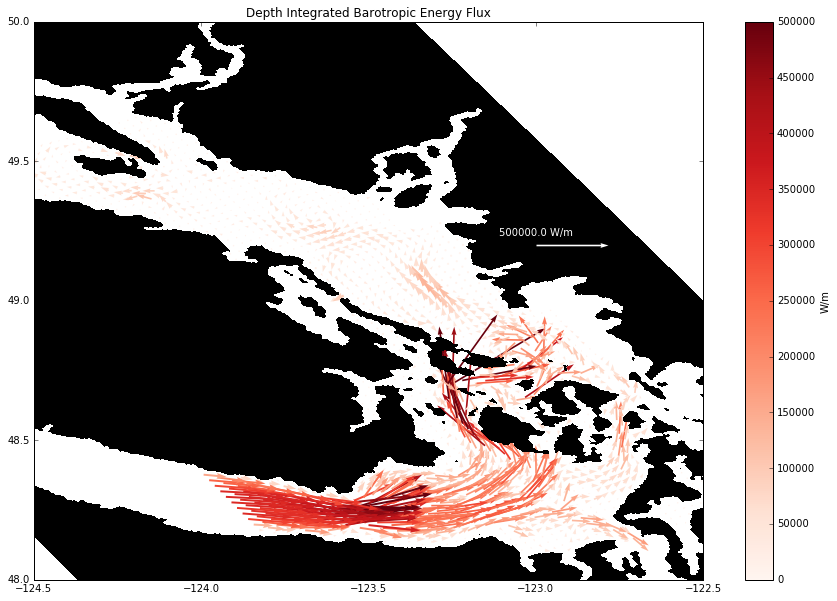

In [12]:
fig,ax=plt.subplots(1,1,figsize=(15,10))
scale=5*1e5
scale_unit='inches'
st=5
for area in ['CODAR', 'BP', 'Victoria', 'JDF', 'NSoG']:
    #depth integrate
    H = np.sum(grids_t[area]['e3t_t'][:,:,1:,1:]*grids[area]['tmask'][:,:,1:,1:],axis=1)
    Fbtu_depint = (Fbtu[area]*H).mean(axis=0)
    Fbtv_depint = (Fbtv[area]*H).mean(axis=0)
    mean_mag = np.sqrt(Fbtu_depint**2 + Fbtv_depint**2 )
    q = ax.quiver(lons[area][::st,::st], lats[area][::st,::st], 
                  Fbtu_depint[::st,::st],
                  Fbtv_depint[::st,::st], 
                  mean_mag[::st,::st],
                  cmap='Reds', scale=scale, scale_units=scale_unit, clim=[0,scale])

ax.quiverkey(q, -123,49.2, scale,'{} W/m'.format(str(scale)),color='w',labelcolor='w',coordinates='data')
cbar=plt.colorbar(q, ax=ax)
cbar.set_label('W/m')
viz_tools.plot_land_mask(ax, grid, coords='map')
ax.set_xlim([-124.5,-122.5])
ax.set_ylim([48,50])
ax.set_title('Depth Integrated Barotropic Energy Flux')

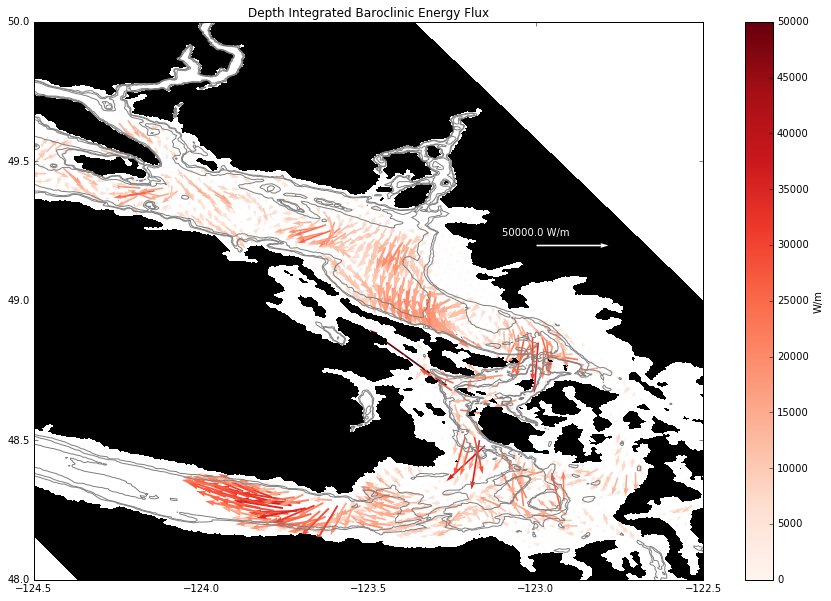

In [11]:
#depth integrate
scale=5*1e4
scale_unit='inches'
st=5
z1=0
z2=40
fig,ax=plt.subplots(1,1,figsize=(15,10))
for area in ['CODAR', 'BP', 'Victoria', 'JDF', 'NSoG']:
    Fbcu_depint = np.sum(Fbcu[area][:,z1:z2,:,:]*grids_t[area]['e3t_t'][:,z1:z2,1:,1:]*grids[area]['tmask'][:,z1:z2,1:,1:],axis=1)
    Fbcv_depint = np.sum(Fbcv[area][:,z1:z2,:,:]*grids_t[area]['e3t_t'][:,z1:z2,1:,1:]*grids[area]['tmask'][:,z1:z2,1:,1:],axis=1)
    Fbcu_depint = Fbcu_depint.mean(axis=0)
    Fbcv_depint = Fbcv_depint.mean(axis=0)
    mean_mag_bc = np.sqrt(Fbcu_depint**2 + Fbcv_depint**2)
    q = ax.quiver(lons[area][::st,::st], lats[area][::st,::st], 
                  Fbcu_depint[::st,::st],
                  Fbcv_depint[::st,::st], 
                  mean_mag_bc[::st,::st],
                  cmap='Reds',  scale=scale, scale_units=scale_unit, clim=[0,scale])
ax.quiverkey(q, -123,49.2,scale,'{} W/m'.format(str(scale)),color='w',labelcolor='w',coordinates='data')
cbar=plt.colorbar(q, ax=ax)
cbar.set_label('W/m')
viz_tools.plot_land_mask(ax, grid, coords='map')
ax.set_xlim([-124.5,-122.5])
ax.set_ylim([48,50])
viz_tools.plot_coastline(ax, grid, coords='map', isobath=100,color='gray')
viz_tools.plot_coastline(ax, grid, coords='map', isobath=125,color='gray')
viz_tools.plot_coastline(ax, grid, coords='map', isobath=200,color='gray')
ax.set_title('Depth Integrated Baroclinic Energy Flux')